# Souporcell + Vireo Donor mapping

## Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cyvcf2 import VCF
import vireoSNP
import glob
import subprocess
import tempfile
import json

## Data directories

In [4]:
# Organize paths in a dictionary
bulk_vcf = "/Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/FreeBayes_bulk_OUTDIR/bulk_rna.vcf.gz"

samples = {
    "FN_S3478": {
        "donor_vcf": "/Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S3478/Vireo_OUTDIR/GT_donors.vireo.vcf.gz",
        "combined_tsv": "/Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S3478/combine_majoritySinglet/combined_results_w_combined_assignments_clean.tsv",
        "outdir": "FN_S3478_bulk_mapping"
    },
    "FN_S1256": {
        "donor_vcf": "/Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S1256/Vireo_OUTDIR/GT_donors.vireo.vcf.gz",
        "combined_tsv": "/Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S1256/combine_majoritySinglet/combined_results_w_combined_assignments_clean.tsv",
        "outdir": "FN_S1256_bulk_mapping"
    }
}

# Example of iterating over samples
for sample_name, paths in samples.items():
    donor_vcf = paths["donor_vcf"]
    combined_tsv = paths["combined_tsv"]
    outdir = paths["outdir"]
    
    print(f"Processing {sample_name}...")
    print(f"Donor VCF: {donor_vcf}")
    print(f"Combined TSV: {combined_tsv}")
    print(f"Output directory: {outdir}")
    print("-" * 40)

Processing FN_S3478...
Donor VCF: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S3478/Vireo_OUTDIR/GT_donors.vireo.vcf.gz
Combined TSV: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S3478/combine_majoritySinglet/combined_results_w_combined_assignments_clean.tsv
Output directory: FN_S3478_bulk_mapping
----------------------------------------
Processing FN_S1256...
Donor VCF: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S1256/Vireo_OUTDIR/GT_donors.vireo.vcf.gz
Combined TSV: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/data/proc/WS_demuxafy/FN_S1256/combine_majoritySinglet/combined_results_w_combined_assignments_clean.tsv
Output directory: FN_S1256_bulk_mapping
----------------------------------------


In [5]:

import os
import pandas as pd
import numpy as np
from cyvcf2 import VCF
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_bulk_genotype_matrix(
    bulk_vcf_file,
    outdir,
    min_maf=0.05,
    min_presence=0.8,
    plot_snps=200
):
    """
    Load bulk RNA VCF, build donor × SNP genotype matrix, filter SNPs, and provide QC summary.
    
    Parameters
    ----------
    bulk_vcf_file : str
        Path to the bulk VCF file (gzipped).
    outdir : str
        Directory to save outputs (CSV, plots).
    min_maf : float, optional
        Minimum minor allele frequency to retain SNPs.
    min_presence : float, optional
        Minimum fraction of donors a SNP must be present in.
    plot_snps : int, optional
        Number of SNPs to include in heatmap plot.
        
    Returns
    -------
    bulk_matrix_filtered : pd.DataFrame
        Filtered donor × SNP genotype matrix.
    """
    
    os.makedirs(outdir, exist_ok=True)
    
    # ------------------------------
    # Load VCF and build matrix
    # ------------------------------
    vcf = VCF(bulk_vcf_file)
    samples = vcf.samples

    variant_ids = []
    gt_rows = []

    for var in vcf:
        vid = f"{var.CHROM}_{var.POS}"
        variant_ids.append(vid)
        row = []
        for gt in var.genotypes:
            if gt[0] is None or gt[1] is None:
                row.append(np.nan)
            else:
                row.append(gt[0] + gt[1])
        gt_rows.append(row)

    bulk_matrix = pd.DataFrame(np.array(gt_rows).T, index=samples, columns=variant_ids, dtype=float)
    print("Raw bulk genotype matrix loaded")
    print(f"Shape: {bulk_matrix.shape} (donors × SNPs)")

    # ------------------------------
    # Compute missingness
    # ------------------------------
    missing_per_snp = bulk_matrix.isna().mean(axis=0)
    missing_per_donor = bulk_matrix.isna().mean(axis=1)

    print(f"Total SNPs: {bulk_matrix.shape[1]}")
    print(f"Mean fraction missing per SNP: {missing_per_snp.mean():.2f}")
    print(f"SNPs with >50% missing: {(missing_per_snp>0.5).sum()}")
    print(f"Mean fraction missing per donor: {missing_per_donor.mean():.2f}")
    print("Top donors with highest missingness:")
    print(missing_per_donor.sort_values(ascending=False).head(10))

    # ------------------------------
    # Filter SNPs
    # ------------------------------
    present_threshold = int(min_presence * bulk_matrix.shape[0])
    bulk_matrix = bulk_matrix.dropna(axis=1, thresh=present_threshold)

    maf = bulk_matrix.mean(axis=0) / 2
    bulk_matrix = bulk_matrix.loc[:, maf >= min_maf]

    print(f"✅ Filtered bulk genotype matrix")
    print(f"Shape after filtering: {bulk_matrix.shape} (donors × SNPs)")

    # Save CSV
    bulk_matrix_path = os.path.join(outdir, "bulk_genotype_matrix_filtered.csv")
    bulk_matrix.to_csv(bulk_matrix_path)
    print(f"✅ Saved filtered bulk matrix: {bulk_matrix_path}")

    # ------------------------------
    # QC summary table
    # ------------------------------
    qc_df = pd.DataFrame({
        "SNP": bulk_matrix.columns,
        "FractionMissing": missing_per_snp[bulk_matrix.columns].values,
        "MAF": maf[bulk_matrix.columns].values
    }).sort_values(by="FractionMissing", ascending=False)
    
    print("\n--- QC summary for filtered SNPs (top 10 shown) ---")
    print(qc_df.head(10).to_string(index=False))

    # ------------------------------
    # Visualization
    # ------------------------------
    if bulk_matrix.shape[1] > 0:
        bulk_plot = bulk_matrix.iloc[:, :plot_snps]
        plt.figure(figsize=(12,6))
        sns.heatmap(bulk_plot, cmap="viridis", cbar_kws={'label':'Genotype (0-2)'})
        plt.title(f"Bulk donor genotypes (first {plot_snps} SNPs)")
        plt.xlabel("SNPs")
        plt.ylabel("Donors")
        plt.show()
    else:
        print(" Warning: No SNPs with sufficient data for plotting.")

    # ------------------------------
    # Automatic interpretation
    # ------------------------------
    print("\n---\nHere’s how to interpret your results:\n")

    print("Raw bulk genotype matrix")
    print(f"\t• Shape: {len(samples)} donors × {len(variant_ids)} SNPs")
    print(f"\t• Missingness:")
    print(f"\t  • Mean fraction missing per SNP = {missing_per_snp.mean():.2f}")
    print(f"\t  • SNPs with >50% missing values = {(missing_per_snp>0.5).sum()}")
    print(f"\t  • Mean fraction missing per donor = {missing_per_donor.mean():.2f}")
    print(f"\t  • Top donors by missingness:\n\t    {missing_per_donor.sort_values(ascending=False).head(10).to_dict()}")
    print("\nConclusion: Your raw VCF contains very complete genotypes.\n")

    print("Filtered bulk genotype matrix")
    removed_snps = len(variant_ids) - bulk_matrix.shape[1]
    print(f"\t• Shape after filtering: {len(samples)} donors × {bulk_matrix.shape[1]} SNPs")
    print(f"\t• Filtering applied:")
    print(f"\t  • Removed SNPs not present in at least {min_presence*100:.0f}% of donors")
    print(f"\t  • Optional MAF filter applied (≥{min_maf})")
    print(f"\t  • Number of SNPs removed: {removed_snps}")
    print("\nConclusion: The filtered matrix retains almost all SNPs and is ready for downstream matching to Vireo/Souporcell output.\n")

    return bulk_matrix




def analyze_bulk_vcf_missingness(bulk_vcf_file, plot_snps=200, 
                                 threshold_options=[0.2,0.3,0.4,0.5]):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from cyvcf2 import VCF
    import os

    """
    Analyze missingness in a bulk RNA-seq VCF file.

    Parameters
    ----------
    bulk_vcf_file : str
        Path to the bulk VCF file (gzipped).
    plot_snps : int, optional
        Number of SNPs to visualize in heatmap (default=200).
    threshold_options : list of float, optional
        F_MISSING thresholds to evaluate SNP retention (default=[0.2,0.3,0.4,0.5]).
    
    Returns
    -------
    gt_matrix : pd.DataFrame
        Donor x SNP genotype matrix with NaN for missing genotypes.
    missing_per_snp_series : pd.Series
        Fraction of missing values per SNP.
    missing_per_donor : pd.Series
        Fraction of missing values per donor.
    """

    # ------------------------------
    # Load VCF and build genotype matrix
    # ------------------------------
    vcf = VCF(bulk_vcf_file)
    samples = vcf.samples

    variant_ids = []
    gt_matrix_rows = []
    missing_per_snp = []

    for var in vcf:
        vid = f"{var.CHROM}_{var.POS}"
        variant_ids.append(vid)
        row = []
        missing_flags = []
        for gt in var.genotypes:  # [allele1, allele2, phased?]
            if gt[0] is None or gt[1] is None:
                row.append(np.nan)
                missing_flags.append(True)
            else:
                row.append(gt[0] + gt[1])
                missing_flags.append(False)
        gt_matrix_rows.append(row)
        missing_per_snp.append(np.mean(missing_flags))

    gt_matrix = pd.DataFrame(np.array(gt_matrix_rows).T, index=samples, columns=variant_ids)
    missing_per_donor = gt_matrix.isna().mean(axis=1)
    missing_per_snp_series = pd.Series(missing_per_snp, index=variant_ids)

    # ------------------------------
    # Print missingness stats
    # ------------------------------
    print(f"Total SNPs: {gt_matrix.shape[1]}")
    print(f"Mean fraction missing per SNP: {missing_per_snp_series.mean():.2f}")
    print(f"SNPs with >50% missing: {(missing_per_snp_series>0.5).sum()}")
    print(f"Mean fraction missing per donor: {missing_per_donor.mean():.2f}")
    print("Top donors with highest missingness:")
    print(missing_per_donor.sort_values(ascending=False).head(10))

    # ------------------------------
    # Suggest F_MISSING thresholds
    # ------------------------------
    print("\nSNP retention by F_MISSING threshold:")
    for t in threshold_options:
        keep_snps = (missing_per_snp_series <= t).sum()
        print(f"F_MISSING <= {t:.2f} keeps {keep_snps} SNPs")

    # ------------------------------
    # Plot missingness distributions
    # ------------------------------
    plt.figure(figsize=(12,5))
    sns.histplot(missing_per_snp_series, bins=50, kde=False)
    for t in threshold_options:
        plt.axvline(t, linestyle='--', color='red', alpha=0.7)
    plt.xlabel("Fraction missing per SNP")
    plt.ylabel("Number of SNPs")
    plt.title("Bulk RNA-seq VCF SNP missingness")
    plt.show()

    plt.figure(figsize=(12,5))
    sns.histplot(missing_per_donor, bins=20, kde=False, color='green')
    plt.xlabel("Fraction missing per donor")
    plt.ylabel("Number of donors")
    plt.title("Bulk RNA-seq VCF donor missingness")
    plt.show()

    return gt_matrix, missing_per_snp_series, missing_per_donor







def Demux_SNP_Heatmap(VCF, WD, vireo_vcf_name, cmap=None, reverse_cmap=False, 
                      border_color="black", row_title=None, col_title=None):
    """
    Generate a heatmap comparing SNPs between a reference VCF and a Vireo SNP VCF.
    Legend title on the left, colorbar on the right.
    Row and column labels fontsize 14, axis titles bold 14pt.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import vireoSNP

    penultimate_folder = os.path.basename(os.path.dirname(os.path.dirname(WD)))
    vireo_vcf = os.path.join(WD, vireo_vcf_name)

    row_title = row_title or os.path.splitext(os.path.basename(vireo_vcf))[0]
    col_title = col_title or os.path.splitext(os.path.basename(VCF))[0]

    # Match SNPs between VCFs
    res = vireoSNP.vcf.match_VCF_samples(vireo_vcf, VCF, GT_tag1="GT", GT_tag2="GT")
    matched_indices = [i for i, diff in enumerate(res["matched_GPb_diff"]) if diff is not None]
    matched_donors1 = [res["matched_donors1"][i] for i in matched_indices]
    matched_donors2 = [res["matched_donors2"][i] for i in matched_indices]
    matched_GPb_diff = np.array([res["matched_GPb_diff"][i] for i in matched_indices])

    if matched_GPb_diff.size == 0:
        print(f"No valid SNP matches found for {penultimate_folder}. No heatmap will be generated.")
        return

    fig, ax = plt.subplots(figsize=(7, 4))

    if cmap and reverse_cmap:
        cmap += "_r"

    if cmap is None:
        vireoSNP.plot.heat_matrix(matched_GPb_diff, matched_donors1, matched_donors2)
    else:
        heatmap = sns.heatmap(
            matched_GPb_diff, 
            cmap=cmap, 
            ax=ax, 
            xticklabels=matched_donors2, 
            yticklabels=matched_donors1, 
            linewidths=0.5, 
            linecolor=border_color,
            cbar=True
        )

        # Configure colorbar
        cbar = heatmap.collections[0].colorbar
        cbar.ax.yaxis.set_ticks_position('right')      # Tick labels on right
        cbar.ax.yaxis.set_label_position('left')      # Title on left
        cbar.ax.yaxis.set_label_coords(-0.3, 0.5)     # x-position of label, centered vertically
        cbar.outline.set_edgecolor(border_color)
        cbar.set_label('Geno Prob Δ (Low → High)', rotation=90, labelpad=100, 
                       fontweight='bold', fontsize=12, va='center')

        # Tick labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=14)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=14)

        # Axis titles
        ax.set_xlabel(col_title, fontsize=14, fontweight='bold')
        ax.set_ylabel(row_title, fontsize=14, fontweight='bold')
        plt.title(f"{penultimate_folder} - Geno Prob Delta: {res['matched_n_var']} SNPs", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(WD, "Geno_Prob_Delta.pdf"))
    plt.show()



    # ----------------------------
    # Helper: auto tick alignment
    # ----------------------------
    def set_tick_labels_auto(ax, xtick_angle=0, ytick_angle=0, label_size=12):
        """
        Automatically sets tick label rotation and alignment based on angle.
        """
        def compute_alignment(angle):
            angle = angle % 360
            if angle == 0:
                ha, va = "center", "top"
            elif 0 < angle < 90:
                ha, va = "right", "top"
            elif angle == 90:
                ha, va = "right", "center"
            elif 90 < angle < 180:
                ha, va = "right", "bottom"
            elif angle == 180:
                ha, va = "center", "bottom"
            elif 180 < angle < 270:
                ha, va = "left", "bottom"
            elif angle == 270:
                ha, va = "left", "center"
            else:  # 270 < angle < 360
                ha, va = "left", "top"
            return ha, va

        # X-axis labels
        ha_x, va_x = compute_alignment(xtick_angle)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_angle, fontsize=label_size,
                           rotation_mode="anchor", ha=ha_x, va=va_x)

        # Y-axis labels
        ha_y, va_y = compute_alignment(ytick_angle)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_angle, fontsize=label_size,
                           rotation_mode="anchor", ha=ha_y, va=va_y)




def prepare_bulk_vcf_summary(
    bulk_vcf_file,
    outdir,
    min_presence=0.8,
    min_maf=0.05,
    max_snps_for_plot=200
):
    """
    Prepare bulk VCF for donor matching and summarize its quality.

    Parameters
    ----------
    bulk_vcf_file : str
        Path to bulk VCF file (bgzipped + indexed).
    outdir : str
        Output directory to save filtered matrix and plots.
    min_presence : float, default 0.8
        Minimum fraction of donors a SNP must be present in to retain.
    min_maf : float, default 0.05
        Minimum minor allele frequency to retain SNP.
    max_snps_for_plot : int, default 200
        Number of SNPs to visualize in heatmap.

    Returns
    -------
    bulk_matrix_filtered : pd.DataFrame
        Filtered donor × SNP genotype matrix.
    summary_dict : dict
        Summary statistics and interpretations.
    """

    import os
    import subprocess
    import sys

    # -----------------------------
    # Check/install packages
    # -----------------------------
    required_packages = ["pandas", "numpy", "matplotlib", "seaborn", "cyvcf2"]
    for pkg in required_packages:
        try:
            __import__(pkg)
        except ImportError:
            print(f"Package '{pkg}' not found. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

    # Imports after ensuring packages
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from cyvcf2 import VCF

    os.makedirs(outdir, exist_ok=True)

    # -----------------------------
    # Load VCF
    # -----------------------------
    vcf = VCF(bulk_vcf_file)
    samples = vcf.samples
    variant_ids = []
    gt_rows = []

    for var in vcf:
        vid = f"{var.CHROM}_{var.POS}"
        variant_ids.append(vid)
        row = []
        for gt in var.genotypes:
            if gt[0] is None or gt[1] is None:
                row.append(np.nan)
            else:
                row.append(gt[0] + gt[1])
        gt_rows.append(row)

    bulk_matrix = pd.DataFrame(np.array(gt_rows).T, index=samples, columns=variant_ids, dtype=float)
    print(f"Raw bulk genotype matrix loaded\nShape: {bulk_matrix.shape} (donors × SNPs)")

    # -----------------------------
    # Compute missingness
    # -----------------------------
    missing_per_snp = bulk_matrix.isna().mean(axis=0)
    missing_per_donor = bulk_matrix.isna().mean(axis=1)

    print(f"Total SNPs: {bulk_matrix.shape[1]}")
    print(f"Mean fraction missing per SNP: {missing_per_snp.mean():.2f}")
    print(f"SNPs with >50% missing: {(missing_per_snp>0.5).sum()}")
    print(f"Mean fraction missing per donor: {missing_per_donor.mean():.2f}")
    print("Top donors with highest missingness:")
    print(missing_per_donor.sort_values(ascending=False).head(10))

    # -----------------------------
    # Filter SNPs
    # -----------------------------
    present_thresh = int(min_presence * bulk_matrix.shape[0])
    bulk_matrix_filtered = bulk_matrix.dropna(axis=1, thresh=present_thresh)

    maf = bulk_matrix_filtered.mean(axis=0) / 2
    bulk_matrix_filtered = bulk_matrix_filtered.loc[:, maf >= min_maf]

    print(f"Filtered bulk genotype matrix\nShape after filtering: {bulk_matrix_filtered.shape} (donors × SNPs)")

    # Save CSV
    bulk_matrix_path = os.path.join(outdir, "bulk_genotype_matrix_filtered.csv")
    bulk_matrix_filtered.to_csv(bulk_matrix_path)
    print(f"Saved filtered bulk matrix: {bulk_matrix_path}")

    # -----------------------------
    # Automatic interpretation
    # -----------------------------
    n_snps_removed = bulk_matrix.shape[1] - bulk_matrix_filtered.shape[1]
    interpretation = f"""
Raw bulk genotype matrix:
  • Shape: {bulk_matrix.shape} → {bulk_matrix.shape[0]} donors × {bulk_matrix.shape[1]} SNPs
  • Mean fraction missing per SNP: {missing_per_snp.mean():.2f} → almost all SNPs have calls
  • No SNP has >50% missing values
  • Mean fraction missing per donor: {missing_per_donor.mean():.2f} → donors complete
  • Top donors missingness: {missing_per_donor.sort_values(ascending=False).head(5).to_dict()}

Filtered bulk genotype matrix:
  • Shape after filtering: {bulk_matrix_filtered.shape} → {bulk_matrix_filtered.shape[0]} donors × {bulk_matrix_filtered.shape[1]} SNPs
  • SNPs removed by filtering: {n_snps_removed} (presence ≥ {min_presence}, MAF ≥ {min_maf})
  • Ready for downstream matching to Vireo/Souporcell output
"""

    print(interpretation)

    # -----------------------------
    # Plot missingness
    # -----------------------------
    plt.figure(figsize=(12,5))
    sns.histplot(missing_per_snp, bins=50, kde=False)
    plt.axvline(1-min_presence, color='red', linestyle='--', label=f'min_presence={min_presence}')
    plt.xlabel("Fraction missing per SNP")
    plt.ylabel("Number of SNPs")
    plt.title("Bulk RNA-seq VCF SNP missingness")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    sns.histplot(missing_per_donor, bins=20, kde=False, color='green')
    plt.xlabel("Fraction missing per donor")
    plt.ylabel("Number of donors")
    plt.title("Bulk RNA-seq VCF donor missingness")
    plt.show()

    # Optional: heatmap first N SNPs
    if bulk_matrix_filtered.shape[1] > 0:
        bulk_plot = bulk_matrix_filtered.iloc[:, :min(max_snps_for_plot, bulk_matrix_filtered.shape[1])]
        plt.figure(figsize=(12,6))
        sns.heatmap(bulk_plot, cmap="viridis", cbar_kws={'label':'Genotype (0-2)'})
        plt.title(f"Bulk donor genotypes (first {bulk_plot.shape[1]} SNPs)")
        plt.xlabel("SNPs")
        plt.ylabel("Donors")
        plt.show()
    else:
        print("⚠️ No SNPs with sufficient data for plotting.")

    summary_dict = {
        "raw_shape": bulk_matrix.shape,
        "filtered_shape": bulk_matrix_filtered.shape,
        "missing_per_snp": missing_per_snp,
        "missing_per_donor": missing_per_donor,
        "interpretation": interpretation
    }

    return bulk_matrix_filtered, summary_dict

## Bulk RNA sample correlations

In [ ]:
def style_colorbar(cbar, label, label_size):
    """Unified publication-style colorbar formatting (Nature/Cell style)."""
    cbar.outline.set_edgecolor("black")
    cbar.outline.set_linewidth(0.2)
    cbar.set_label(label, fontsize=label_size, fontweight="bold", labelpad=8)
    cbar.ax.tick_params(axis="y", labelsize=label_size, width=0.2, length=3, direction="out")
    cbar.ax.set_facecolor("none")


def vcf_sample_correlation(
    vcf_path,
    corr_method="pearson",
    heatmap=True,
    annotate=True,
    cmap="coolwarm",
    cluster=False,
    pdf_path=None,
    plot_title="Sample Correlation",
    label_size=8,                  
    xtick_angle=45,
    ytick_angle=0,
    single_column_width_mm=85      
):
    """
    Compute pairwise sample correlation from a VCF file and visualize
    as a publication-ready heatmap (Nature / Cell style).
    """

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from cyvcf2 import VCF

    # --------------------------------------------------
    # Output directory (same parent as VCF)
    # --------------------------------------------------
    vcf_dir = os.path.dirname(os.path.abspath(vcf_path))
    outdir = os.path.join(vcf_dir, "vcf_sample_correlation_out")
    os.makedirs(outdir, exist_ok=True)

    # --------------------------------------------------
    # Global matplotlib style
    # --------------------------------------------------
    plt.rcParams.update({
        "font.family": "Helvetica",
        "font.size": label_size
    })

    # --------------------------------------------------
    # Read VCF
    # --------------------------------------------------
    vcf = VCF(vcf_path)
    samples = vcf.samples
    n = len(samples)

    sum_x = np.zeros(n)
    sum_x2 = np.zeros(n)
    sum_xy = np.zeros((n, n))
    count_x = np.zeros(n)
    count_xy = np.zeros((n, n))

    for var in vcf:
        gt = var.genotypes
        g = np.array(
            [g[0] + g[1] if None not in g[:2] else np.nan for g in gt],
            dtype=float
        )

        mask = ~np.isnan(g)
        sum_x[mask] += g[mask]
        sum_x2[mask] += g[mask] ** 2
        count_x[mask] += 1

        idx = np.where(mask)[0]
        gi = g[idx]
        for i in range(len(idx)):
            for j in range(i, len(idx)):
                si, sj = idx[i], idx[j]
                sum_xy[si, sj] += gi[i] * gi[j]
                sum_xy[sj, si] = sum_xy[si, sj]
                count_xy[si, sj] += 1
                count_xy[sj, si] = count_xy[si, sj]

    mean_x = sum_x / np.maximum(count_x, 1)
    var_x = sum_x2 / np.maximum(count_x, 1) - mean_x**2
    std_x = np.sqrt(np.maximum(var_x, 1e-12))

    cor = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if count_xy[i, j] == 0:
                cor[i, j] = np.nan
            else:
                cov = (sum_xy[i, j] / count_xy[i, j]) - mean_x[i] * mean_x[j]
                cor[i, j] = cov / (std_x[i] * std_x[j])

    cor_df = pd.DataFrame(cor, index=samples, columns=samples)

    if corr_method.lower() == "spearman":
        cor_df = cor_df.rank().corr(method="pearson")

    # --------------------------------------------------
    # Save correlation table
    # --------------------------------------------------
    csv_path = os.path.join(outdir, "VCF_sample_correlation.csv")
    cor_df.to_csv(csv_path)

    if not heatmap:
        return cor_df

    # --------------------------------------------------
    # Figure sizing (publication-ready)
    # --------------------------------------------------
    # Tight, aligned colorbar
    fig, ax = plt.subplots(figsize=(max(4, n*0.3), max(3, n*0.3)))

    # --------------------------------------------------
    # Heatmap
    # --------------------------------------------------
    sns.heatmap(
        cor_df,
        ax=ax,
        cmap=cmap,
        square=True,
        linewidths=0.2,
        linecolor="black",
        annot=annotate,
        fmt=".2f",
        annot_kws={"fontsize": max(label_size - 2, 4)}
    )

    # --------------------------------------------------
    # Colorbar styling (same as run_bulk_donor_mapping)
    # --------------------------------------------------
    cbar = ax.collections[0].colorbar
    cbar.outline.set_edgecolor("black")
    cbar.outline.set_linewidth(0.2)
    cbar.set_label(
        f"{corr_method.capitalize()} correlation",
        fontsize=label_size,
        fontweight="bold",
        labelpad=6
    )
    cbar.ax.tick_params(
        axis="y",
        labelsize=label_size,
        width=0.2,
        length=3,
        direction="out"
    )

    # --------------------------------------------------
    # Axes formatting
    # --------------------------------------------------
    ax.set_title(plot_title, fontsize=label_size, fontweight="bold", pad=6)

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=xtick_angle,
        ha="right",
        fontsize=label_size
    )
    
    ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=ytick_angle,
    ha="right",
    fontsize=label_size
    )

    ax.tick_params(width=0.2, length=3)

    for spine in ax.spines.values():
        spine.set_linewidth(0.2)
        spine.set_edgecolor("black")

    # --------------------------------------------------
    # Save figures
    # --------------------------------------------------
    for ext in ["pdf", "png", "tiff"]:
        fig.savefig(
            os.path.join(outdir, f"VCF_sample_correlation.{ext}"),
            dpi=600,
            bbox_inches="tight"
        )

    plt.show()

    print(f"Saved plots + table in: {outdir}")
    return cor_df



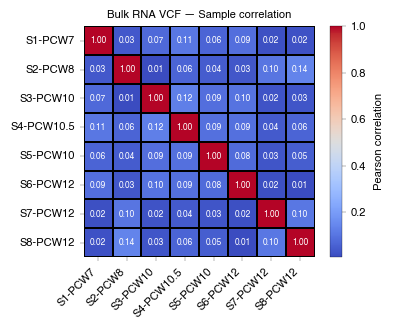

Saved plots + table in: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca-nose/data/FreeBayes_bulk_OUTDIR/vcf_sample_correlation_out


In [10]:
cor_matrix = vcf_sample_correlation(
    vcf_path=bulk_vcf,
    plot_title="Bulk RNA VCF — Sample correlation"
)

In [11]:
cor_matrix

,S1-PCW7,S2-PCW8,S3-PCW10,S4-PCW10.5,S5-PCW10,S6-PCW12,S7-PCW12,S8-PCW12
S1-PCW7,1.000000,0.034333,0.073500,0.106269,0.061196,0.085016,0.015844,0.021042
S2-PCW8,0.034333,1.000000,0.006104,0.063985,0.044393,0.032719,0.099615,0.135124
S3-PCW10,0.073500,0.006104,1.000000,0.124025,0.087048,0.095765,0.023334,0.026796
S4-PCW10.5,0.106269,0.063985,0.124025,1.000000,0.087764,0.088855,0.038132,0.061587
S5-PCW10,0.061196,0.044393,0.087048,0.087764,1.000000,0.078572,0.027479,0.046444
S6-PCW12,0.085016,0.032719,0.095765,0.088855,0.078572,1.000000,0.016653,0.008065
S7-PCW12,0.015844,0.099615,0.023334,0.038132,0.027479,0.016653,1.000000,0.103872
S8-PCW12,0.021042,0.135124,0.026796,0.061587,0.046444,0.008065,0.103872,1.000000


## Bulk RNA QC

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import json

def prepare_bulk_vcf_summary(
    bulk_vcf_file,
    outdir,
    min_presence=0.8,
    min_maf=0.05,
    max_snps_for_plot=200,
    fig_name="Figure"
):
    """
    Prepare bulk VCF, generate publication-style plots, and save reproducible TSV source data.

    Parameters
    ----------
    bulk_vcf_file : str
        Path to bulk VCF file (bgzipped + indexed).
    outdir : str
        Output directory to save filtered matrix, plots, and source data.
    min_presence : float, default 0.8
        Minimum fraction of donors a SNP must be present in to retain.
    min_maf : float, default 0.05
        Minimum minor allele frequency to retain SNP.
    max_snps_for_plot : int, default 200
        Number of SNPs to visualize in heatmap (not included here, can extend).
    fig_name : str, default "Figure"
        Base name for figure and TSV files.

    Returns
    -------
    bulk_matrix_filtered : pd.DataFrame
        Filtered donor × SNP genotype matrix.
    summary_dict : dict
        Summary statistics and interpretations.
    """

    os.makedirs(outdir, exist_ok=True)

    # -----------------------------
    # Load VCF
    # -----------------------------
    vcf = VCF(bulk_vcf_file)
    samples = vcf.samples
    variant_ids = []
    gt_rows = []

    for var in vcf:
        vid = f"{var.CHROM}_{var.POS}"
        variant_ids.append(vid)
        row = []
        for gt in var.genotypes:
            if gt[0] is None or gt[1] is None:
                row.append(np.nan)
            else:
                row.append(gt[0] + gt[1])
        gt_rows.append(row)

    bulk_matrix = pd.DataFrame(np.array(gt_rows).T, index=samples, columns=variant_ids, dtype=float)

    # -----------------------------
    # Compute missingness
    # -----------------------------
    missing_per_snp = bulk_matrix.isna().mean(axis=0)
    missing_per_donor = bulk_matrix.isna().mean(axis=1)

    # -----------------------------
    # Filter SNPs
    # -----------------------------
    present_thresh = int(min_presence * bulk_matrix.shape[0])
    bulk_matrix_filtered = bulk_matrix.dropna(axis=1, thresh=present_thresh)
    maf_list = bulk_matrix_filtered.mean(axis=0) / 2
    bulk_matrix_filtered = bulk_matrix_filtered.loc[:, maf_list >= min_maf]
    maf_list = maf_list[bulk_matrix_filtered.columns]

    # -----------------------------
    # Summary dictionary
    # -----------------------------
    summary_dict = {
        "raw_shape": bulk_matrix.shape,
        "filtered_shape": bulk_matrix_filtered.shape,
        "missing_per_snp": missing_per_snp,
        "missing_per_donor": missing_per_donor,
        "maf": maf_list
    }

    # -----------------------------
    # Save filtered matrix TSV
    # -----------------------------
    filtered_matrix_tsv = os.path.join(outdir, "bulk_genotype_matrix_filtered.tsv")
    bulk_matrix_filtered.to_csv(filtered_matrix_tsv, sep="\t")
    print(f"✅ Filtered bulk matrix saved (TSV): {filtered_matrix_tsv}")

    # Save summary JSON
    summary_path = os.path.join(outdir, "bulk_genotype_summary.json")
    with open(summary_path, "w") as f:
        json.dump({
            k: (v.to_dict() if isinstance(v, pd.Series) else str(v))
            for k,v in summary_dict.items()
        }, f, indent=2)
    print(f"✅ Summary JSON saved: {summary_path}")

    # -----------------------------
    # Plotting settings
    # -----------------------------
    sns.set_theme(style="white")
    plt.rcParams.update({
        "figure.dpi": 600,
        "savefig.dpi": 600,
        "axes.linewidth": 0.6,
        "xtick.major.width": 0.6,
        "ytick.major.width": 0.6,
        "font.size": 8,
        "axes.titlesize": 9,
        "axes.labelsize": 8,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
    })

    okabe_ito = [
        "#000000", "#E69F00", "#56B4E9", "#009E73",
        "#F0E442", "#0072B2", "#D55E00", "#CC79A7"
    ]

    # -----------------------------
    # 1. SNP missingness plot + TSV
    # -----------------------------
    fig, ax = plt.subplots(figsize=(3.2, 2.4))
    sns.histplot(missing_per_snp, bins=40, color=okabe_ito[2], edgecolor="white", linewidth=0.3, ax=ax)
    ax.set_title("SNP missingness", pad=6)
    ax.set_xlabel("Missingness per SNP")
    ax.set_ylabel("Number of SNPs")
    sns.despine(ax=ax)
    plt.tight_layout()
    for ext in ["pdf","png","tiff"]:
        fig.savefig(os.path.join(outdir, f"{fig_name}_missingness.{ext}"), dpi=600, bbox_inches="tight")
    plt.show(fig)

    # Save TSV for reproducibility
    missingness_tsv = os.path.join(outdir, f"{fig_name}_missingness.tsv")
    missing_per_snp.to_frame(name="missingness").to_csv(missingness_tsv, sep="\t")
    print(f"✅ SNP missingness TSV saved: {missingness_tsv}")

    # -----------------------------
    # 2. Donor call rate plot + TSV
    # -----------------------------
    call_rate = 1 - missing_per_donor
    fig, ax = plt.subplots(figsize=(3.2, 2.4))
    sns.barplot(x=samples, y=call_rate.values, color=okabe_ito[3], edgecolor="black", linewidth=0.3, ax=ax)
    ax.set_title("Donor call rate", pad=6)
    ax.set_ylabel("Call rate")
    ax.set_xlabel("")
    ax.set_ylim(0,1)
    ax.axhline(0.95, color="grey", linestyle="--", linewidth=0.6)
    ax.set_xticklabels(samples, rotation=45, ha="right")
    sns.despine(ax=ax)
    plt.tight_layout()
    for ext in ["pdf","png","tiff"]:
        fig.savefig(os.path.join(outdir, f"{fig_name}_callrate.{ext}"), dpi=600, bbox_inches="tight")
    plt.show(fig)

    # Save TSV
    callrate_tsv = os.path.join(outdir, f"{fig_name}_callrate.tsv")
    call_rate.to_frame(name="call_rate").to_csv(callrate_tsv, sep="\t")
    print(f"✅ Donor call rate TSV saved: {callrate_tsv}")

    # -----------------------------
    # 3. MAF distribution plot + TSV
    # -----------------------------
    fig, ax = plt.subplots(figsize=(3.2, 2.4))
    sns.histplot(maf_list, bins=40, color=okabe_ito[5], edgecolor="white", linewidth=0.3, ax=ax)
    ax.set_title("Minor allele frequency", pad=6)
    ax.set_xlabel("MAF")
    ax.set_ylabel("Number of SNPs")
    sns.despine(ax=ax)
    plt.tight_layout()
    for ext in ["pdf","png","tiff"]:
        fig.savefig(os.path.join(outdir, f"{fig_name}_maf.{ext}"), dpi=600, bbox_inches="tight")
    plt.show(fig)

    # Save TSV
    maf_tsv = os.path.join(outdir, f"{fig_name}_maf.tsv")
    maf_list.to_frame(name="maf").to_csv(maf_tsv, sep="\t")
    print(f"✅ MAF TSV saved: {maf_tsv}")

    return bulk_matrix_filtered, summary_dict

✅ Filtered bulk matrix saved (TSV): /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/out/bulk_summary/bulk_genotype_matrix_filtered.tsv
✅ Summary JSON saved: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/out/bulk_summary/bulk_genotype_summary.json


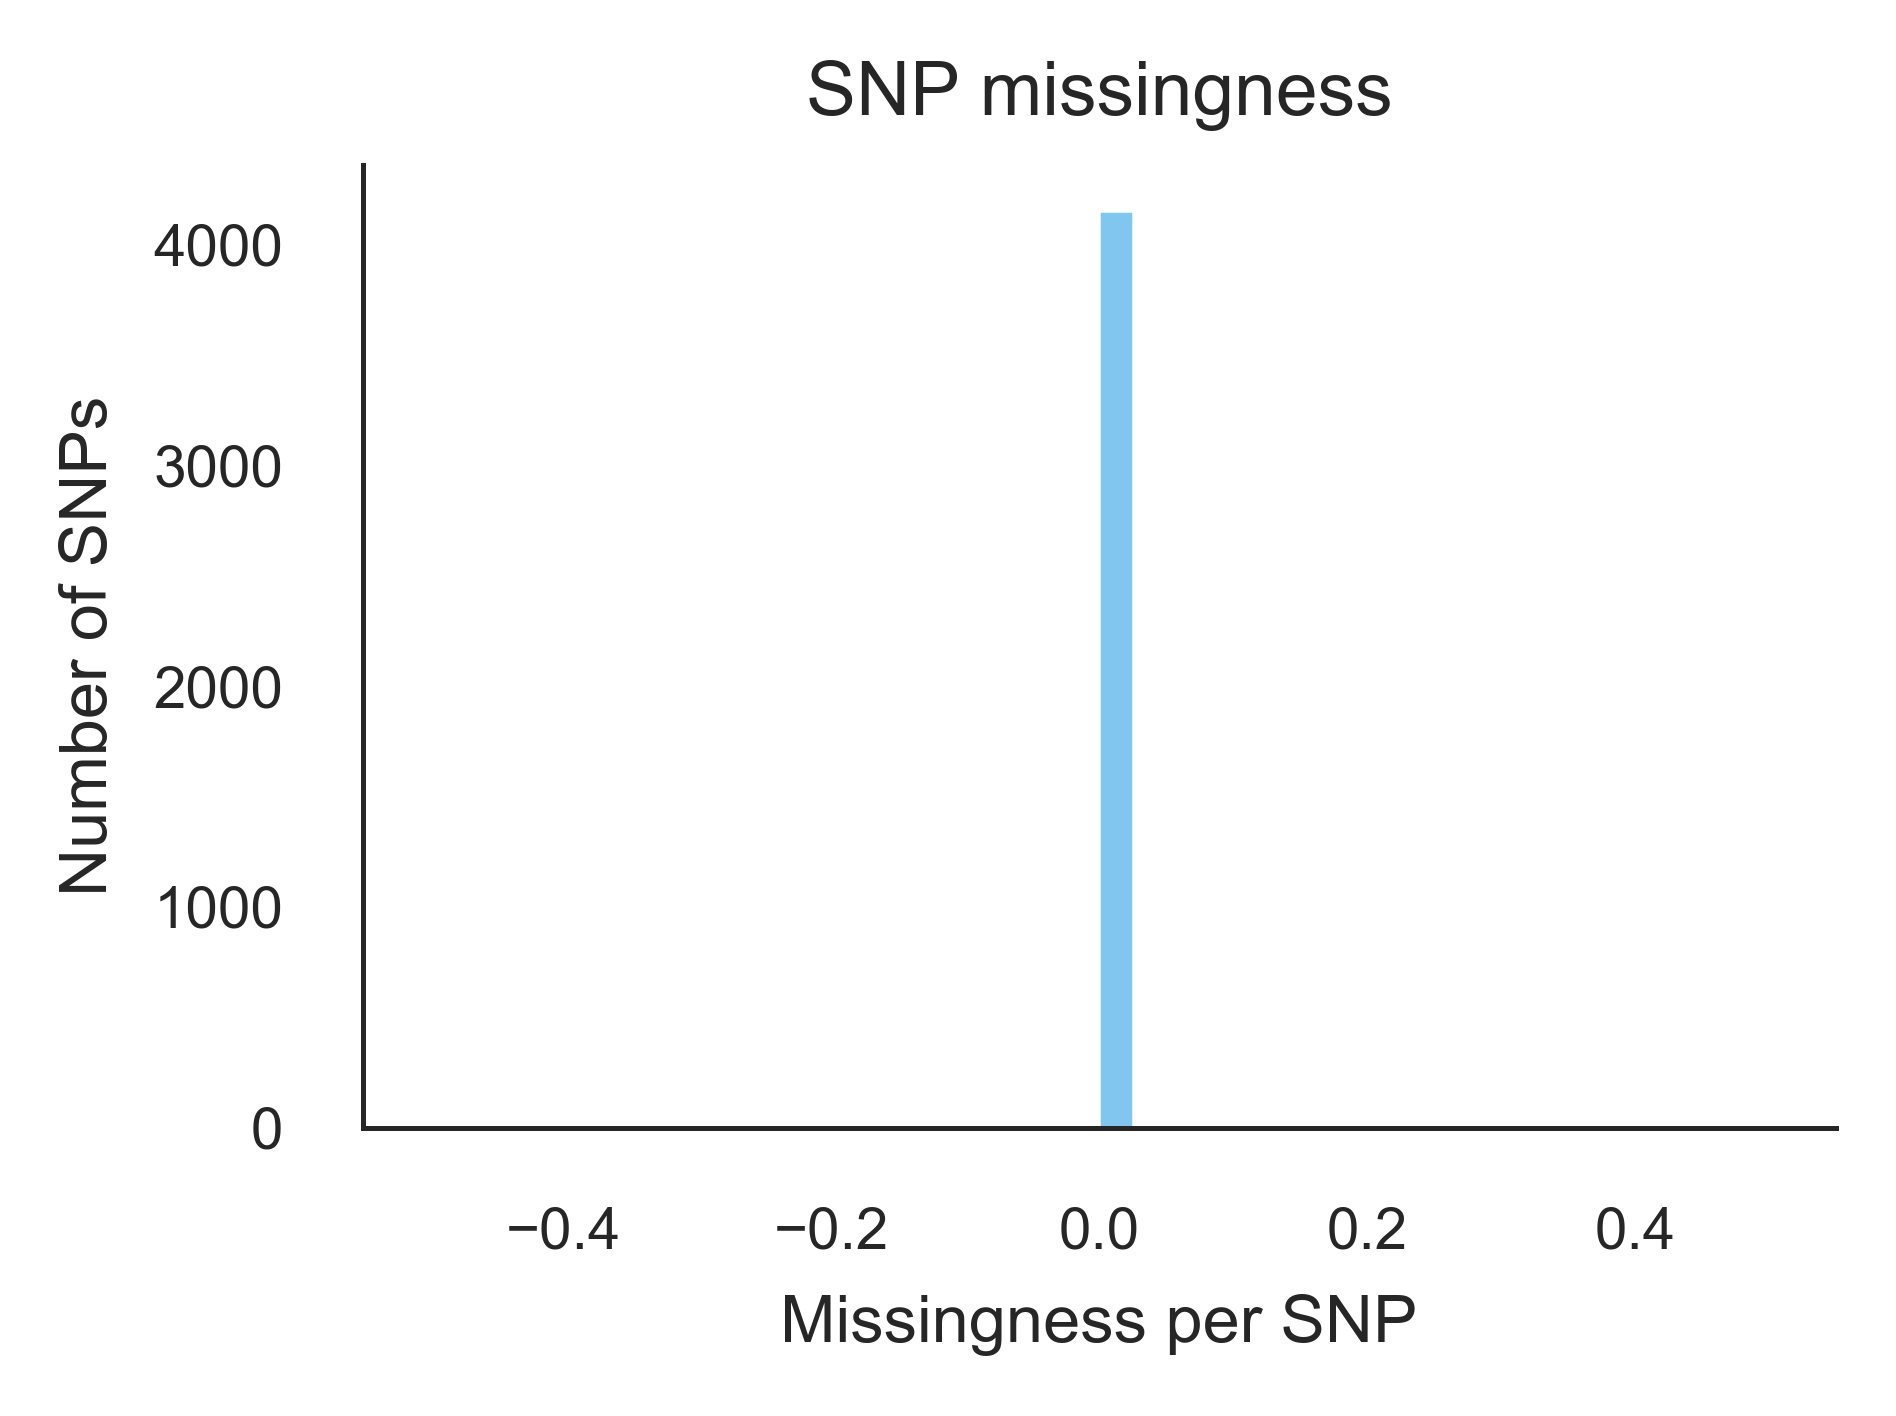

✅ SNP missingness TSV saved: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/out/bulk_summary/FigS1_missingness.tsv


/var/folders/km/8h7qg1817m7gygf9pyqz_hv4_j20yx/T/ipykernel_7501/237122376.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(samples, rotation=45, ha="right")


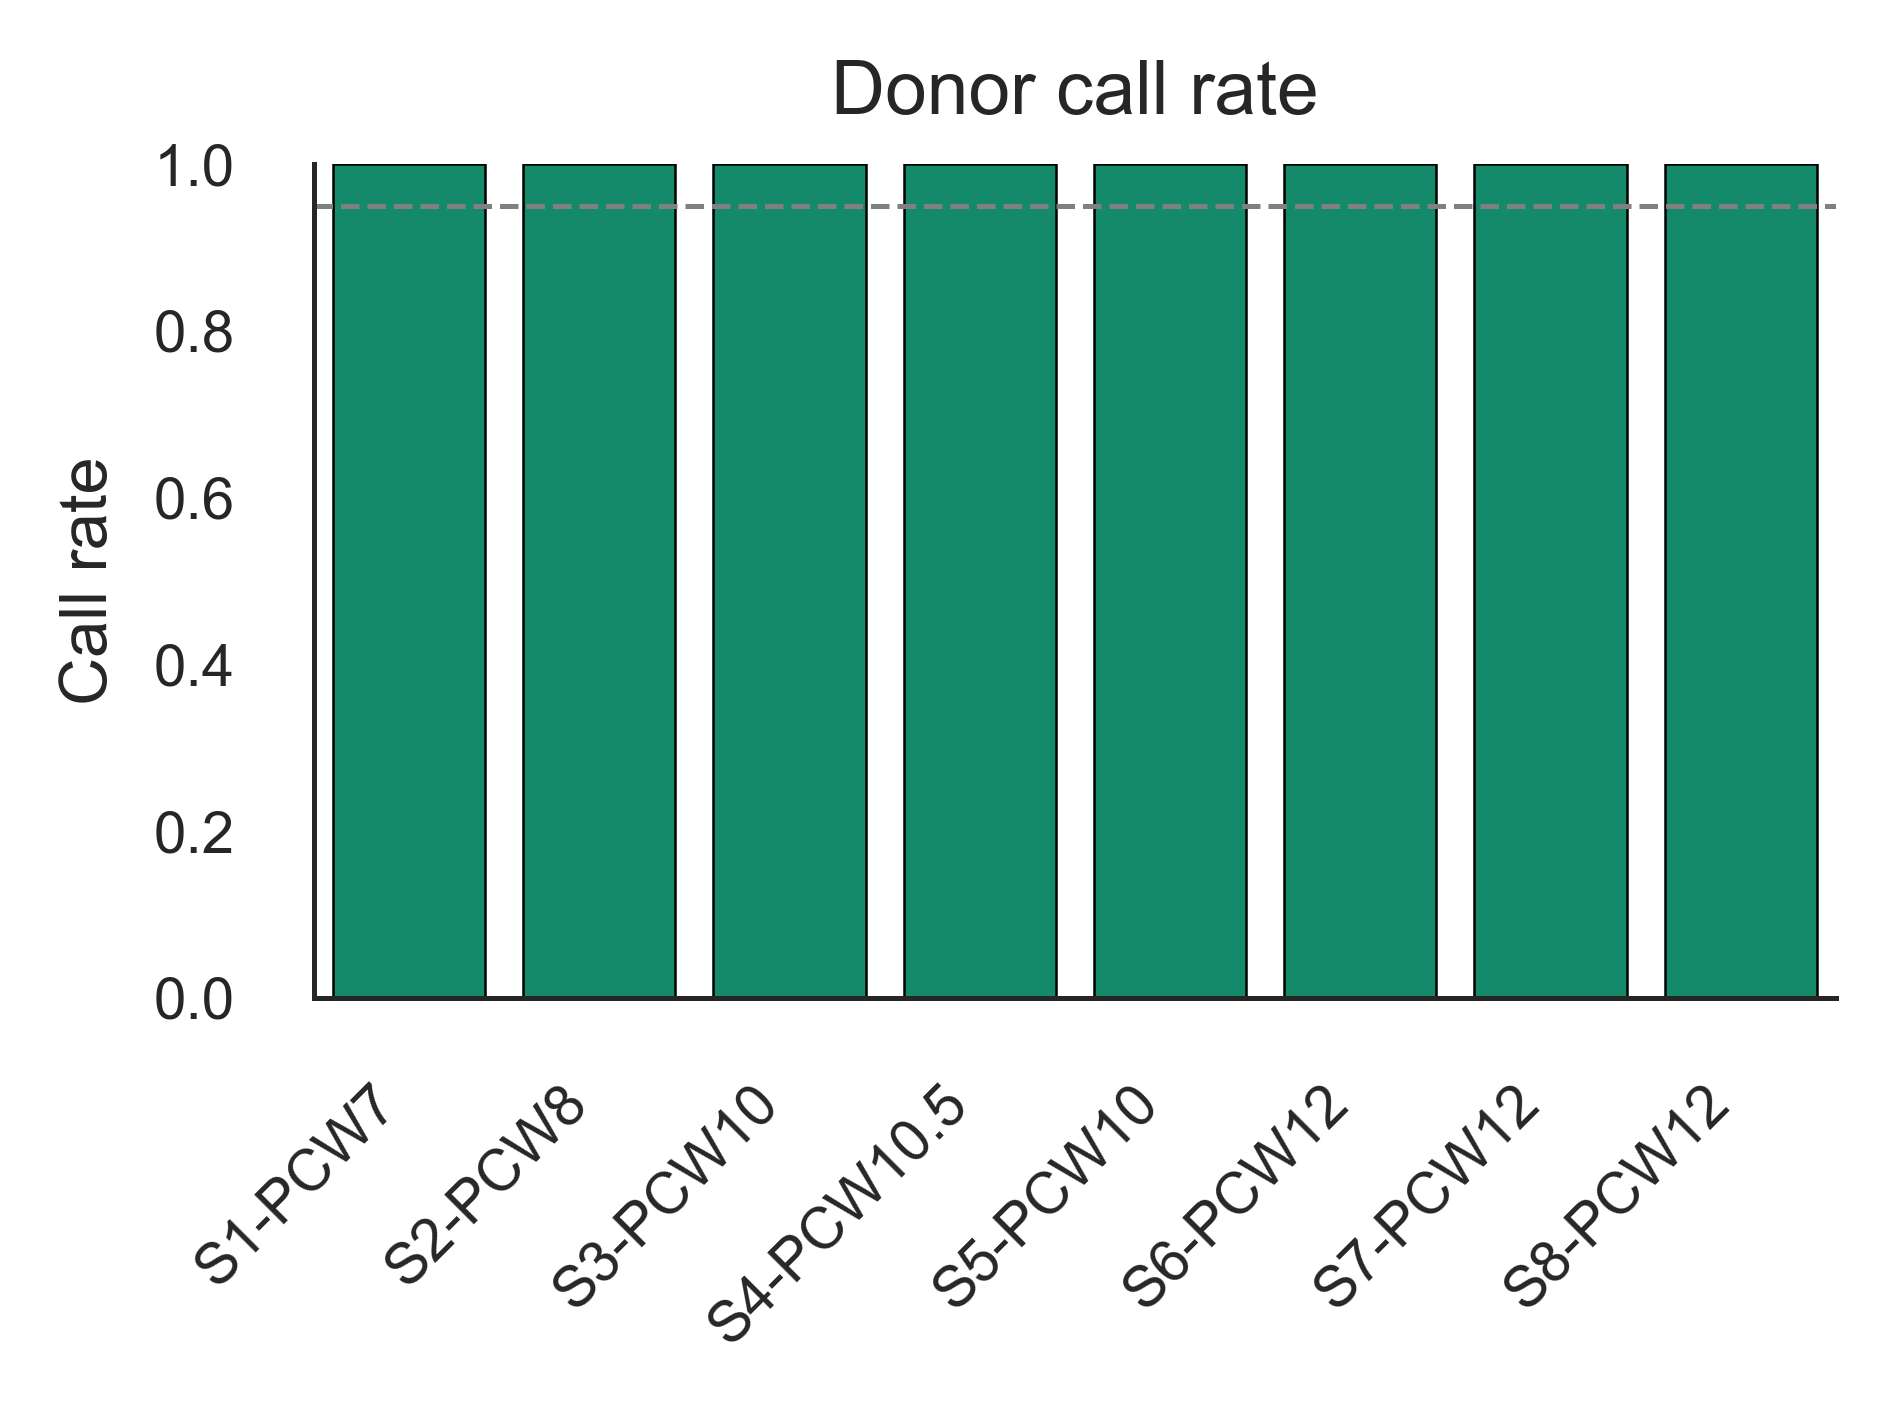

✅ Donor call rate TSV saved: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/out/bulk_summary/FigS1_callrate.tsv


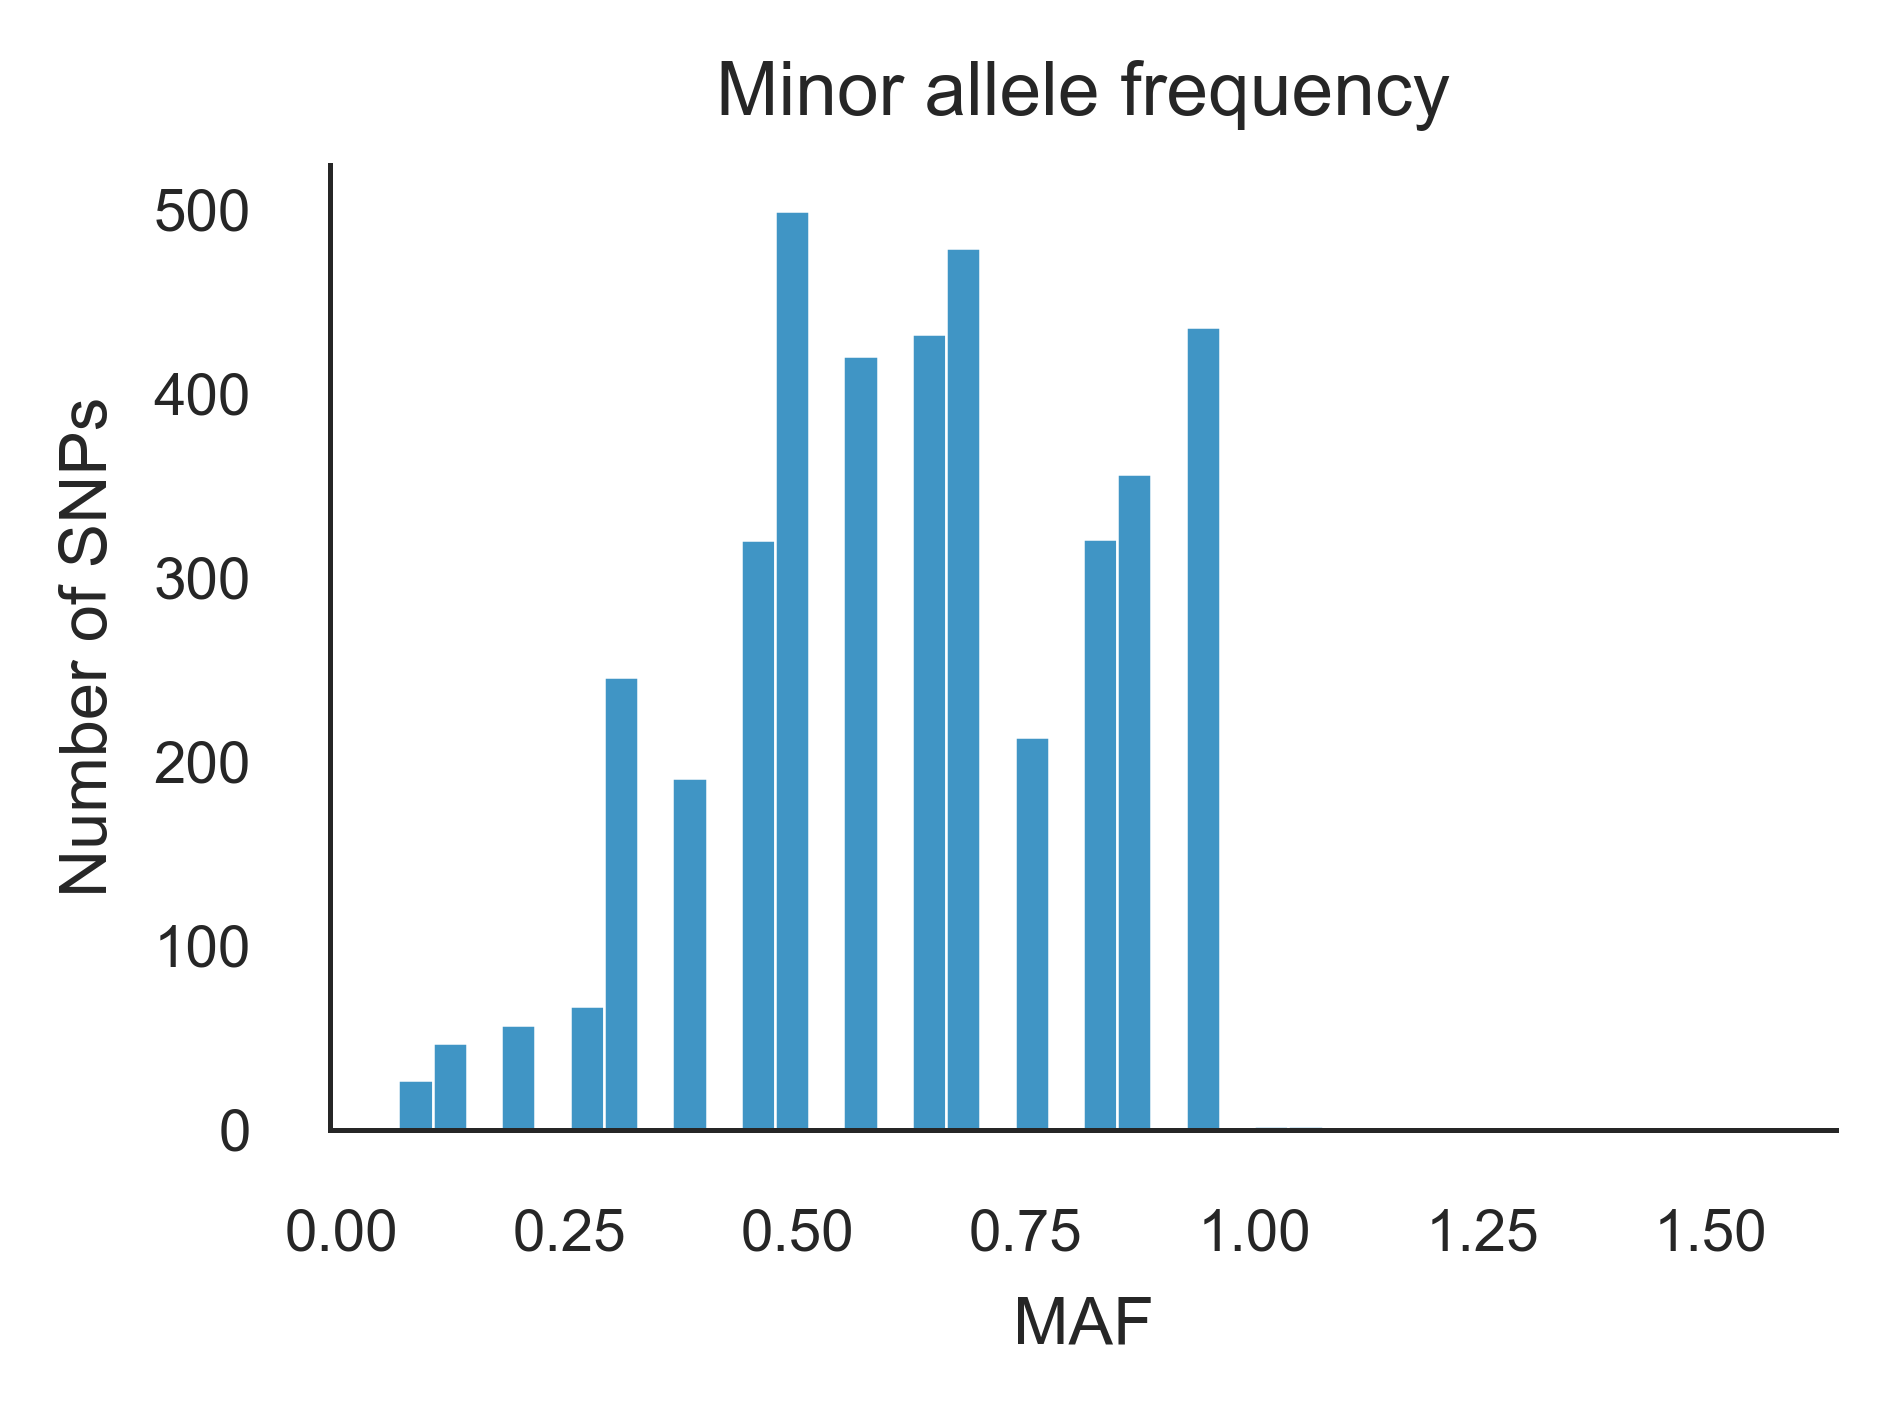

✅ MAF TSV saved: /Users/yvon.mbouamboua/projects/singlecell/000-hudeca/out/bulk_summary/FigS1_maf.tsv


In [30]:
outdir = "/Users/yvon.mbouamboua/projects/singlecell/000-hudeca/out/bulk_summary"

bulk_matrix_filtered, summary = prepare_bulk_vcf_summary(
    bulk_vcf,
    outdir,
    min_presence=0.8,
    min_maf=0.05,
    max_snps_for_plot=200,
    fig_name="FigS1"
)

## Bulk donor mapping

In [6]:
def style_colorbar(cbar, label, label_size):
    """Unified publication-style colorbar formatting (Nature/Cell style)."""
    cbar.outline.set_edgecolor("black")
    cbar.outline.set_linewidth(0.2)
    cbar.set_label(label, fontsize=label_size, fontweight="bold", labelpad=8)
    cbar.ax.tick_params(axis="y", labelsize=label_size, width=0.2, length=3, direction="out")
    cbar.ax.set_facecolor("none")


def run_bulk_donor_mapping(
    bulk_vcf,
    donor_vcf,
    combined_tsv,
    outdir,
    min_concordance=0.6,
    ambiguity_delta=0.05,
    multiplex_name=None,
    border_color="black",
    cmap="viridis",
    label_size=8,
    xtick_angle=45,
    ytick_angle=0,
    ha_x="right",
    ha_y="center",
    single_column_width_mm=85
):
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from cyvcf2 import VCF

    os.makedirs(outdir, exist_ok=True)

    # --------------------------------------------------
    # Figure sizing (Nature single-column)
    # --------------------------------------------------
    fig_width = single_column_width_mm / 25.4  # mm → inches

    plt.rcParams.update({
        "font.family": "Helvetica",
        "font.size": label_size
    })

    # --------------------------------------------------
    # Helper
    # --------------------------------------------------
    def gt_to_ac(gt):
        if gt is None or gt[0] < 0 or gt[1] < 0:
            return np.nan
        return gt[0] + gt[1]

    # --------------------------------------------------
    # Load donor VCF
    # --------------------------------------------------
    donor_vcf_obj = VCF(donor_vcf)
    donor_samples = donor_vcf_obj.samples
    donor_dict = {}

    for v in donor_vcf_obj:
        key = f"{v.CHROM}:{v.POS}:{v.REF}:{','.join(v.ALT)}"
        donor_dict[key] = np.array([gt_to_ac(gt) for gt in v.genotypes])

    donor_vcf_obj.close()

    # --------------------------------------------------
    # Load bulk VCF (restricted to shared variants)
    # --------------------------------------------------
    bulk_vcf_obj = VCF(bulk_vcf)
    bulk_samples = bulk_vcf_obj.samples

    bulk_rows, keys = [], []

    for v in bulk_vcf_obj:
        key = f"{v.CHROM}:{v.POS}:{v.REF}:{','.join(v.ALT)}"
        if key in donor_dict:
            ac = np.array([gt_to_ac(gt) for gt in v.genotypes])
            if not np.all(np.isnan(ac)):
                bulk_rows.append(ac)
                keys.append(key)

    bulk_vcf_obj.close()

    donor_gt = np.vstack([donor_dict[k] for k in keys])
    bulk_gt = np.vstack(bulk_rows)

    # --------------------------------------------------
    # Concordance calculation
    # --------------------------------------------------
    concordance = pd.DataFrame(index=donor_samples, columns=bulk_samples)

    for i, d in enumerate(donor_samples):
        for j, b in enumerate(bulk_samples):
            mask = ~np.isnan(donor_gt[:, i]) & ~np.isnan(bulk_gt[:, j])
            concordance.loc[d, b] = (
                (donor_gt[mask, i] == bulk_gt[mask, j]).mean()
                if mask.sum() > 0 else np.nan
            )

    concordance = concordance.astype(float)

    donor_to_bulk = concordance.idxmax(axis=1).to_dict()

    # --------------------------------------------------
    # Save concordance matrix
    # --------------------------------------------------
    concordance_path = os.path.join(outdir, "donor_bulk_concordance.tsv")
    concordance.to_csv(concordance_path, sep="\t")
    print(f"✔ Concordance matrix saved to: {concordance_path}")

    # --------------------------------------------------
    # Load combined TSV & add bulk mapping
    # --------------------------------------------------
    combined_df = pd.read_csv(combined_tsv, sep="\t")

    combined_df["BulkSample"] = combined_df["Vireo_Individual_Assignment"].map(donor_to_bulk)
    combined_df["BulkSample"] = combined_df["BulkSample"].fillna("unassigned")

    # --------------------------------------------------
    # Save combined results
    # --------------------------------------------------
    combined_out = os.path.join(outdir, "combined_results_with_bulk_mapping.tsv")
    combined_df.to_csv(combined_out, sep="\t", index=False)
    print(f"✔ Combined results saved to: {combined_out}")

    # --------------------------------------------------
    # Consensus heatmap (Vireo | Souporcell)
    # --------------------------------------------------
    combined_df["Vireo_vs_Souporcell"] = (
        combined_df["Vireo_Individual_Assignment"].astype(str) + " | " +
        combined_df["Souporcell_Individual_Assignment"].astype(str)
    )

    mat = pd.crosstab(
        combined_df["Vireo_vs_Souporcell"],
        combined_df["BulkSample"]
    )

    row_order = mat.sum(axis=1).sort_values(ascending=False).index
    col_order = mat.sum(axis=0).sort_values(ascending=False).index
    mat = mat.loc[row_order, col_order]

    fig_height = max(2.5, len(row_order) * 0.25)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    bbox = ax.get_position()
    cbar_ax = fig.add_axes([bbox.x1 + 0.02, bbox.y0, 0.03, bbox.height])

    sns.heatmap(
        mat,
        ax=ax,
        cmap=cmap,
        linewidths=0.2,
        linecolor=border_color,
        cbar_ax=cbar_ax,
        annot=True,
        fmt="d",
        annot_kws={"fontsize": max(label_size - 2, 4)}
    )

    style_colorbar(ax.collections[0].colorbar, "Fraction of cells", label_size)

    ax.set_title(f"{multiplex_name} — Consensus assignments", fontweight="bold", fontsize=label_size)
    ax.set_xlabel("Bulk samples", fontsize=label_size)
    ax.set_ylabel("Vireo | Souporcell", fontsize=label_size)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_angle, ha=ha_x, fontsize=label_size)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_angle, ha=ha_y, fontsize=label_size)

    for ext in ["pdf", "png", "tiff"]:
        plt.savefig(os.path.join(outdir, f"consensus_heatmap.{ext}"),
                    dpi=600, bbox_inches="tight")
    plt.show()

    # --------------------------------------------------
    # Geno prob Δ heatmap (vireoSNP)
    # --------------------------------------------------
    try:
        import vireoSNP

        res = vireoSNP.vcf.match_VCF_samples(
            donor_vcf, bulk_vcf, GT_tag1="GT", GT_tag2="GT"
        )

        diff = np.array(res["matched_GPb_diff"])
        donors = res["matched_donors1"]
        bulks = res["matched_donors2"]

        mapped_idx = [i for i, d in enumerate(donors) if donor_to_bulk.get(d) is not None]

        if mapped_idx:
            diff = diff[mapped_idx, :]
            donors = [donors[i] for i in mapped_idx]

            mapped_bulk = set(donor_to_bulk.values())
            cols_to_keep = [i for i, b in enumerate(bulks) if b in mapped_bulk]

            if cols_to_keep:
                diff = diff[:, cols_to_keep]
                bulks = [bulks[i] for i in cols_to_keep]
            else:
                diff = None
        else:
            diff = None

        if diff is not None:
            fig_height = max(2.0, len(donors) * 0.25)
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))
            bbox = ax.get_position()
            cbar_ax = fig.add_axes([bbox.x1 + 0.02, bbox.y0, 0.03, bbox.height])

            sns.heatmap(
                diff,
                ax=ax,
                cmap=cmap,
                linewidths=0.2,
                linecolor=border_color,
                cbar_ax=cbar_ax,
                xticklabels=bulks,
                yticklabels=donors,
                annot=np.round(diff, 2),
                fmt=".2f",
                annot_kws={"fontsize": max(label_size - 2, 4)}
            )

            style_colorbar(ax.collections[0].colorbar, "Geno prob Δ", label_size)

            ax.set_title(f"{multiplex_name} — Geno prob delta",
                         fontweight="bold", fontsize=label_size)
            ax.set_xlabel("Bulk samples", fontsize=label_size)
            ax.set_ylabel("Vireo donors", fontsize=label_size)
            ax.set_xticklabels(ax.get_xticklabels(),
                               rotation=xtick_angle, ha=ha_x, fontsize=label_size)
            ax.set_yticklabels(ax.get_yticklabels(),
                               rotation=ytick_angle, ha=ha_y, fontsize=label_size)

            for ext in ["pdf", "png", "tiff"]:
                plt.savefig(os.path.join(outdir, f"geno_prob_delta_heatmap.{ext}"),
                            dpi=600, bbox_inches="tight")
            plt.show()

    except Exception as e:
        print("Skipping Geno prob Δ heatmap:", e)

    return combined_df, concordance

[W::vcf_parse] Contig 'chr10' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse_info] INFO 'AD' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'DP' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'OTH' is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'GT' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'AD' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'DP' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'PL' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse] Contig 'chr11' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'chr12' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_par

✔ Concordance matrix saved to: FN_S3478_bulk_mapping/donor_bulk_concordance.tsv
✔ Combined results saved to: FN_S3478_bulk_mapping/combined_results_with_bulk_mapping.tsv


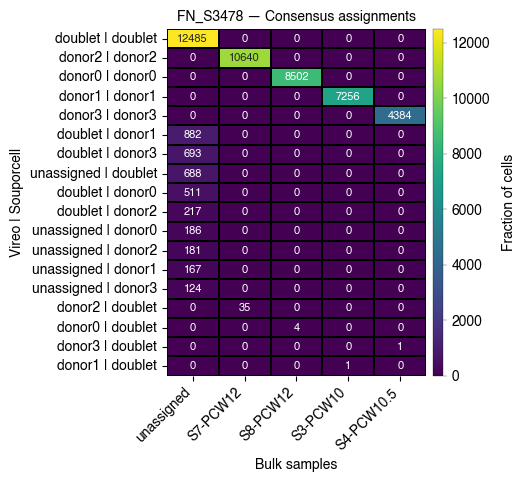

Shape for Geno Prob in VCF1: (751514, 4, 3)
Shape for Geno Prob in VCF2: (4112, 8, 3)
n_variants in VCF1, VCF2 and matched: 751514, 4112, 1665
aligned donors:
['donor0' 'donor1' 'donor2' 'donor3']
['S8-PCW12' 'S3-PCW10' 'S7-PCW12' 'S4-PCW10.5']


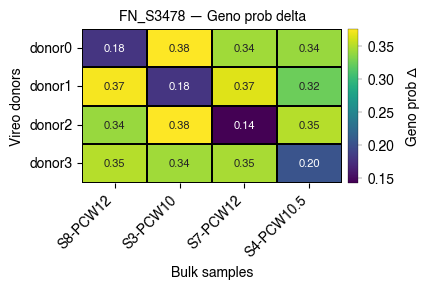

[W::vcf_parse] Contig 'chr10' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse_info] INFO 'AD' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'DP' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'OTH' is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'GT' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'AD' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'DP' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse_format_dict2] FORMAT 'PL' at chr10:62159 is not defined in the header, assuming Type=String
[W::vcf_parse] Contig 'chr11' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'chr12' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_par

✔ Concordance matrix saved to: FN_S1256_bulk_mapping/donor_bulk_concordance.tsv
✔ Combined results saved to: FN_S1256_bulk_mapping/combined_results_with_bulk_mapping.tsv


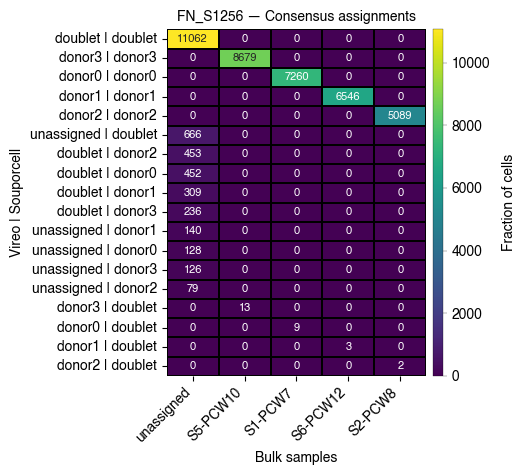

Shape for Geno Prob in VCF1: (660895, 4, 3)
Shape for Geno Prob in VCF2: (4112, 8, 3)
n_variants in VCF1, VCF2 and matched: 660895, 4112, 1490
aligned donors:
['donor0' 'donor1' 'donor2' 'donor3']
['S1-PCW7' 'S6-PCW12' 'S2-PCW8' 'S5-PCW10']


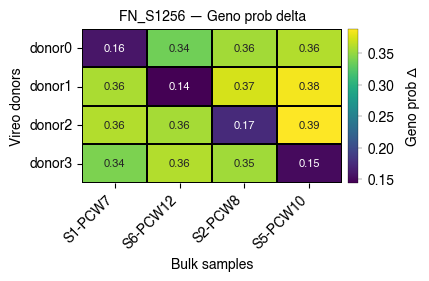

In [7]:
for sample_name, paths in samples.items():
    combined_df, mapping_df = run_bulk_donor_mapping(
        bulk_vcf=bulk_vcf,
        donor_vcf=paths["donor_vcf"],
        combined_tsv=paths["combined_tsv"],
        outdir=paths["outdir"],
        min_concordance=0.6,
        ambiguity_delta=0.05,
        label_size=10,
        border_color="black",
        xtick_angle=45,
        ytick_angle=0,
        ha_x="right",
        ha_y="right",
        multiplex_name=sample_name
    )